# Setup

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

Model evaluation functions

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate(model, X_test, y_true, title=''):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=15, y=1.2)

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(131)
    plt.imshow(cm, cmap='GnBu')
    plt.colorbar()
    for i, j in [[0,0], [0,1], [1,0], [1,1]]:
        plt.text(i, j, cm[i,j], 
                 color='white', ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.25))

    plt.xticks(np.arange(0, 2, step=1)) 
    plt.yticks(np.arange(1, -1, step=-1))   
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.grid(False)

    # Plot ROC curve
    plt.subplot(132)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Plot precision recall curve
    plt.subplot(133)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    plt.step(recall, precision, color='orange', where='post')
    plt.legend(['Average Precision (AP = %0.4f)' % average_precision])
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.5, 0.2)
    plt.show()
    
    print(classification_report(y_true, y_pred))

In [3]:
import shap

def shap_summery(model, X_train, X_test):
    explainer = shap.LinearExplainer(clf, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [4]:
# Inoput - X_test_enc (encoded testing data) with true and predicted labels, 
# feature to check bias for and privilaged class in the feature
def check_bias(df, feature, priv_class):
    print("Checking for bias based on", feature)
    print("Privileged class", priv_class)
    print("-----------------------------------------------")
    # Calculate confusion matrix
    y_true_p, y_pred_p = df[df[feature] == priv_class].true, df[df[feature] == priv_class].predicted
    TN_p, FP_p, FN_p, TP_p = confusion_matrix(y_true_p, y_pred_p).ravel()
    y_true_u, y_pred_u = df[df[feature] != priv_class].true, df[df[feature] != priv_class].predicted
    TN_u, FP_u, FN_u, TP_u = confusion_matrix(y_true_u, y_pred_u).ravel()
    # Calculate metrics of bias
    # rate of +ve outcome privilaged
    rate_pos_outcome_p = (TP_p + FP_p)/(TN_p + FP_p + FN_p + TP_p)
    # rate of +ve outcome unprivilaged
    rate_pos_outcome_u = (TP_u + FP_u)/(TN_u + FP_u + FN_u + TP_u)
    # Statistical piraty: diff of the rate of +ve outcomes of unprivileged to the privileged group
    stat_piraty = rate_pos_outcome_u - rate_pos_outcome_p
    # Equal oppurtunity: diff of true +ve rates of unprivileged and the privileged group
    eq_odds_diff = TP_u/(TP_u + FN_u) - TP_p/(TP_p + FN_p)
    # Avg odds diff: average of difference in false +ve rates and true +ve rates between unprivileged 
    # and privileged group
    avg_odds_diff = ((FP_u/(FP_u + TN_u) - FP_p/(FP_p + TN_p)) + eq_odds_diff)/2
    # Disparate Impact: ratio of prob of +ve outcomes between the unprivileged and privileged group
    disp_impact = rate_pos_outcome_u / rate_pos_outcome_p

    res = pd.DataFrame(index=['Statistical Parity Difference', 'Equal Opportunity Difference', 
                              'Average Odds Difference', 'Disparate Impact'])
    res['value'] = [stat_piraty, eq_odds_diff, avg_odds_diff, disp_impact]
    res['biased'] = [~i for i in [-0.1 < stat_piraty < 0.1, -0.1 < eq_odds_diff < 0.1, 
                     -0.1 < avg_odds_diff < 0.1, 0.8 < disp_impact < 1.25 ]]

    print(res, '\n')

# Task 3.2 - Data Analysis

## 3.2.1 Load dataset

In [5]:
FEATURES = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
            "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

CONTINUOUS = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
DISCRETE = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "salary"]

data = pd.read_csv("adult.csv", na_values='?', names=FEATURES)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  47985 non-null  object
 14  salary          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## 3.2.2 Inspect different demographic groups within the data

Distribution of numerical features

In [6]:
num_info = data[CONTINUOUS].describe().transpose()
num_info.drop(columns=['count'], axis=0, inplace=True)
num_info['var'] = [data[i].var() for i in CONTINUOUS]
num_info.transpose()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
mean,38.644,"189,664.135",10.078,"1,079.068",87.502,40.422
std,13.711,"105,604.025",2.571,"7,452.019",403.005,12.391
min,17.000,"12,285.000",1.000,0.000,0.000,1.000
25%,28.000,"117,550.500",9.000,0.000,0.000,40.000
50%,37.000,"178,144.500",10.000,0.000,0.000,40.000
75%,48.000,"237,642.000",12.000,0.000,0.000,45.000
max,90.000,"1,490,400.000",16.000,"99,999.000","4,356.000",99.000
var,187.978,"11,152,210,185.575",6.610,"55,532,588.036","162,412.669",153.548


Distribution of selective numerical features with seperated by the outcome of the target variable

In [7]:
continuous = ['age', 'education_num', 'hours_per_week']
data[continuous+['salary']].groupby(['salary']).agg(['count', 'mean', 'std', 'var']).transpose()

salary                    <=50K       >50K
age            count 37,155.000 11,687.000
               mean      36.872     44.275
               std       14.104     10.559
               var      198.926    111.492
education_num  count 37,155.000 11,687.000
               mean       9.598     11.603
               std        2.438      2.383
               var        5.942      5.677
hours_per_week count 37,155.000 11,687.000
               mean      38.840     45.453
               std       12.357     11.091
               var      152.692    123.014

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `sex`

In [8]:
data[continuous+['salary','sex']].groupby(['sex', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

sex                      Female                 Male          
salary                    <=50K      >50K      <=50K      >50K
age            count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      36.279    42.219     37.249    44.642
               std       14.387    10.505     13.909    10.527
               var      206.999   110.352    193.448   110.818
education_num  count 14,423.000 1,769.000 22,732.000 9,918.000
               mean       9.825    11.832      9.455    11.562
               std        2.307     2.202      2.507     2.411
               var        5.322     4.849      6.283     5.814
hours_per_week count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      35.876    40.679     40.721    46.304
               std       11.855    11.854     12.300    10.729
               var      140.542   140.511    151.295   115.117

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `race`

In [9]:
data[continuous+['salary','race']].groupby(['race', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

race                 Amer-Indian-Eskimo        Asian-Pac-Islander          \
salary                            <=50K   >50K              <=50K    >50K   
age            count            415.000 55.000          1,110.000 409.000   
               mean              36.128 40.964             36.220  42.306   
               std               12.368  9.469             13.403   9.972   
               var              152.957 89.665            179.627  99.448   
education_num  count            415.000 55.000          1,110.000 409.000   
               mean               9.176 10.982             10.477  12.416   
               std                2.151  2.198              2.768   2.406   
               var                4.628  4.833              7.660   5.788   
hours_per_week count            415.000 55.000          1,110.000 409.000   
               mean              39.817 43.709             38.013  44.966   
               std               12.256  8.956             12.572  10.705   
               var              150.213 80.210            158.049 114.602   

race                     Black           Other             White             
salary                   <=50K    >50K   <=50K   >50K      <=50K       >50K  
age            count 4,119.000 566.000 356.000 50.000 31,155.000 10,607.000  
               mean     37.052  44.193  32.685 40.580     36.929     44.390  
               std      13.026   9.768  11.735  9.227     14.303     10.621  
               var     169.685  95.405 137.704 85.147    204.582    112.803  
education_num  count 4,119.000 566.000 356.000 50.000 31,155.000 10,607.000  
               mean      9.273  11.076   8.466 11.500      9.629     11.603  
               std       2.243   2.342   3.093  3.079      2.433      2.373  
               var       5.031   5.483   9.568  9.480      5.919      5.630  
hours_per_week count 4,119.000 566.000 356.000 50.000 31,155.000 10,607.000  
               mean     37.825  44.223  38.489 44.280     38.995     45.552  
               std      10.113  10.292  10.741  9.461     12.627     11.160  
               var     102.263 105.929 115.377 89.512    159.446    124.545

Analysing categorical data

In [10]:
for i in DISCRETE[:-1]:
    print("Demographic group: ", i)
    print("3 most frequent values: " + ', '.join(data[i].value_counts()[:3].index.tolist()))
    unq = data[i].unique()
    info = pd.DataFrame(columns=["Count"], index=unq)
    info["Count"] = [data[data[i] == j].shape[0] for j in unq]
    info[">50K (%)"] = [data[(data[i] == j) & (data.salary == '>50K')].shape[0] for j in unq]
    info[">50K (%)"] = np.round(info[">50K (%)"]/info["Count"], 3)
    info = info.sort_values(by=['>50K (%)'], ascending=False)
    print("Population size and % of population earning >50K a year for this demographic as described below")
    display(info.transpose())
    print("")


Demographic group:  workclass
3 most frequent values: Private, Self-emp-not-inc, Local-gov
Population size and % of population earning >50K a year for this demographic as described below


,Self-emp-inc,Federal-gov,Local-gov,Self-emp-not-inc,State-gov,Private,Without-pay,Never-worked,NaN
Count,"1,695.000","1,432.000","3,136.000","3,862.000","1,981.000","33,906.000",21.000,10.000,0.000
>50K (%),0.553,0.392,0.296,0.279,0.268,0.218,0.095,0.000,NaN



Demographic group:  education
3 most frequent values: HS-grad, Some-college, Bachelors
Population size and % of population earning >50K a year for this demographic as described below


,Prof-school,Doctorate,Masters,Bachelors,Assoc-acdm,Assoc-voc,Some-college,HS-grad,12th,7th-8th,10th,9th,5th-6th,11th,1st-4th,Preschool
Count,834.000,594.000,"2,657.000","8,025.000","1,601.000","2,061.000","10,878.000","15,784.000",657.000,955.000,"1,389.000",756.000,509.000,"1,812.000",247.000,83.000
>50K (%),0.740,0.726,0.549,0.413,0.258,0.253,0.190,0.159,0.073,0.065,0.063,0.054,0.053,0.051,0.032,0.012



Demographic group:  marital_status
3 most frequent values: Married-civ-spouse, Never-married, Divorced
Population size and % of population earning >50K a year for this demographic as described below


,Married-civ-spouse,Married-AF-spouse,Divorced,Married-spouse-absent,Widowed,Separated,Never-married
Count,"22,379.000",37.000,"6,633.000",628.000,"1,518.000","1,530.000","16,117.000"
>50K (%),0.446,0.378,0.101,0.092,0.084,0.065,0.045



Demographic group:  occupation
3 most frequent values: Prof-specialty, Craft-repair, Exec-managerial
Population size and % of population earning >50K a year for this demographic as described below


,Exec-managerial,Prof-specialty,Armed-Forces,Protective-serv,Tech-support,Sales,Craft-repair,Transport-moving,Adm-clerical,Machine-op-inspct,Farming-fishing,Handlers-cleaners,Other-service,Priv-house-serv,NaN
Count,"6,086.000","6,172.000",15.000,983.000,"1,446.000","5,504.000","6,112.000","2,355.000","5,611.000","3,022.000","1,490.000","2,072.000","4,923.000",242.000,0.000
>50K (%),0.478,0.451,0.333,0.313,0.290,0.268,0.226,0.204,0.137,0.123,0.116,0.067,0.041,0.012,NaN



Demographic group:  relationship
3 most frequent values: Husband, Not-in-family, Own-child
Population size and % of population earning >50K a year for this demographic as described below


,Wife,Husband,Not-in-family,Unmarried,Other-relative,Own-child
Count,"2,331.000","19,716.000","12,583.000","5,125.000","1,506.000","7,581.000"
>50K (%),0.469,0.449,0.101,0.060,0.035,0.015



Demographic group:  race
3 most frequent values: White, Black, Asian-Pac-Islander
Population size and % of population earning >50K a year for this demographic as described below


,Asian-Pac-Islander,White,Other,Black,Amer-Indian-Eskimo
Count,"1,519.000","41,762.000",406.000,"4,685.000",470.000
>50K (%),0.269,0.254,0.123,0.121,0.117



Demographic group:  sex
3 most frequent values: Male, Female
Population size and % of population earning >50K a year for this demographic as described below


,Male,Female
Count,"32,650.000","16,192.000"
>50K (%),0.304,0.109



Demographic group:  native_country
3 most frequent values: United-States, Mexico, Philippines
Population size and % of population earning >50K a year for this demographic as described below


,France,India,Taiwan,Iran,England,Greece,Yugoslavia,Japan,Canada,Italy,...,Trinadad&Tobago,El-Salvador,Nicaragua,Mexico,Dominican-Republic,Columbia,Outlying-US(Guam-USVI-etc),Guatemala,Holand-Netherlands,NaN
Count,38.000,151.000,65.000,59.000,127.000,49.000,23.000,92.000,182.000,105.000,...,27.000,155.000,49.000,951.000,103.000,85.000,23.000,88.000,1.000,0.000
>50K (%),0.421,0.411,0.400,0.373,0.370,0.367,0.348,0.348,0.346,0.324,...,0.074,0.071,0.061,0.049,0.049,0.047,0.043,0.034,0.000,NaN


# Task 3.3 - Conventional implementation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Data preparation for ML 

In [12]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [13]:
# Removing anomalies form the data
# Removing individual of age over 80 years working full time because it is highly unsual
data = data[~((data['age'] >= 80) & (data['hours_per_week'] >= 20))]
data.shape

(45111, 15)

In [14]:
# Encode native-country, salary and race
data['native_country'] = data['native_country'].apply(lambda x: 1 if x == "United-States" else 0)
data['salary'] = data['salary'].map(lambda x : 1 if x == '>50K' else 0)
data['race'] = data['race'].apply(lambda x: "White" if x == "White" else "non-White")


# Encode marital-status
data['marital_status'] = data['marital_status'].replace(
    ['Divorced','Married-spouse-absent','Never-married','Separated','Widowed'], 0)
data['marital_status'] = data['marital_status'].replace(['Married-AF-spouse','Married-civ-spouse'], 1)


# Simplify workclass
def workclass(x):
    if 'gov' in x:
        return 'gov'
    elif x == 'Private':
        return 'private'
    elif x == 'Self-emp-inc':
        return 'self_employed'
    else:
        return 'without_pay'

data['workclass'] = data['workclass'].apply(workclass)


# Simplify occupation
def occupation(x):
    if x in ['Adm-clerical', 'Exec-managerial']:
        return 'White-Collar'
    elif x in ['Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Transport-moving']:
        return 'Blue-Collar'
    elif x in ['Other-service', 'Priv-house-serv', 'Protective-serv', 'Tech-support']:
        return 'Service'
    elif x == 'Prof-specialty':
        return 'Professional'
    else:
        return x

data['occupation'] = data['occupation'].apply(occupation)


# Encode capital_gain and capital_loss
data['capital_gain'] = data['capital_gain'].map(lambda x: 1 if x > 0 else 0)
data['capital_loss'] = data['capital_loss'].map(lambda x: 1 if x > 0 else 0)
CONTINUOUS.remove('capital_gain')
CONTINUOUS.remove('capital_loss')
DISCRETE += ['capital_gain', 'capital_loss']


# Normalize continuous features
data[CONTINUOUS] = (data[CONTINUOUS] - data[CONTINUOUS].mean())/data[CONTINUOUS].std()

data = data.drop(['education'], axis=1)
data

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,0.043,gov,-1.062,1.129,0,White-Collar,Not-in-family,White,Male,1,0,-0.079,1,0
1,0.888,without_pay,-1.008,1.129,1,White-Collar,Husband,White,Male,0,0,-2.329,1,0
2,-0.033,private,0.245,-0.439,0,Blue-Collar,Not-in-family,White,Male,0,0,-0.079,1,0
3,1.118,private,0.425,-1.224,1,Blue-Collar,Husband,non-White,Male,0,0,-0.079,1,0
4,-0.801,private,1.406,1.129,1,Professional,Wife,non-White,Female,0,0,-0.079,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,-0.417,private,0.524,1.129,0,Professional,Own-child,White,Male,0,0,-0.079,1,0
45218,0.043,private,0.242,1.129,0,Professional,Not-in-family,White,Female,0,0,-0.412,1,0
45219,-0.033,private,1.752,1.129,1,Professional,Husband,White,Male,0,0,0.754,1,0
45220,0.427,private,-1.002,1.129,0,White-Collar,Own-child,non-White,Male,1,0,-0.079,1,0


## 3.3.2 Naively splitting the dataset into training and testing dataset

In [15]:
enc_columns = ['workclass', 'occupation', 'relationship', 'sex', 'race']
X = data.drop(['salary'], axis=1)
y = data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_enc = pd.get_dummies(X_train, columns=enc_columns, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=enc_columns, drop_first=True)

## 3.3.3 Training, test and evaluate model

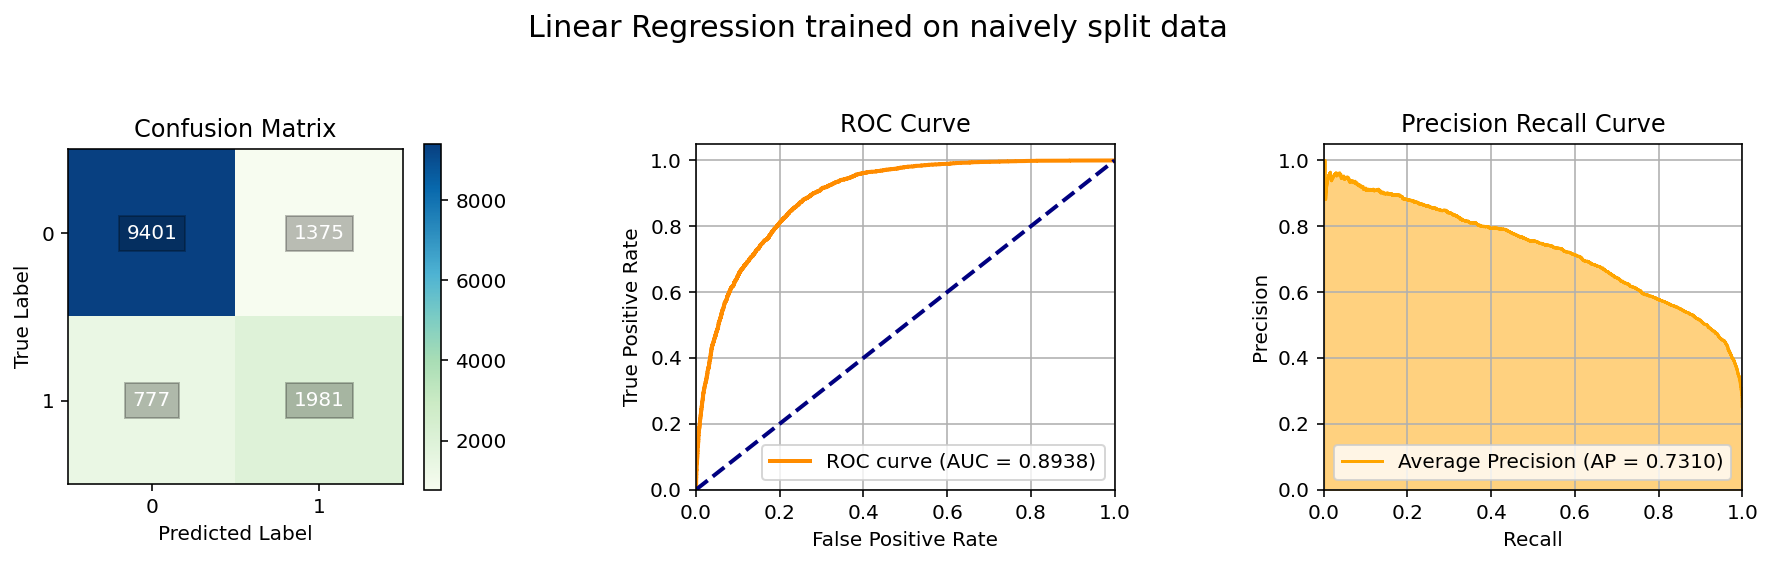

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     10178
           1       0.72      0.59      0.65      3356

    accuracy                           0.84     13534
   macro avg       0.80      0.76      0.77     13534
weighted avg       0.83      0.84      0.84     13534



In [16]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train_enc, y_train)
evaluate(clf, X_test_enc, y_test, 'Linear Regression trained on naively split data')

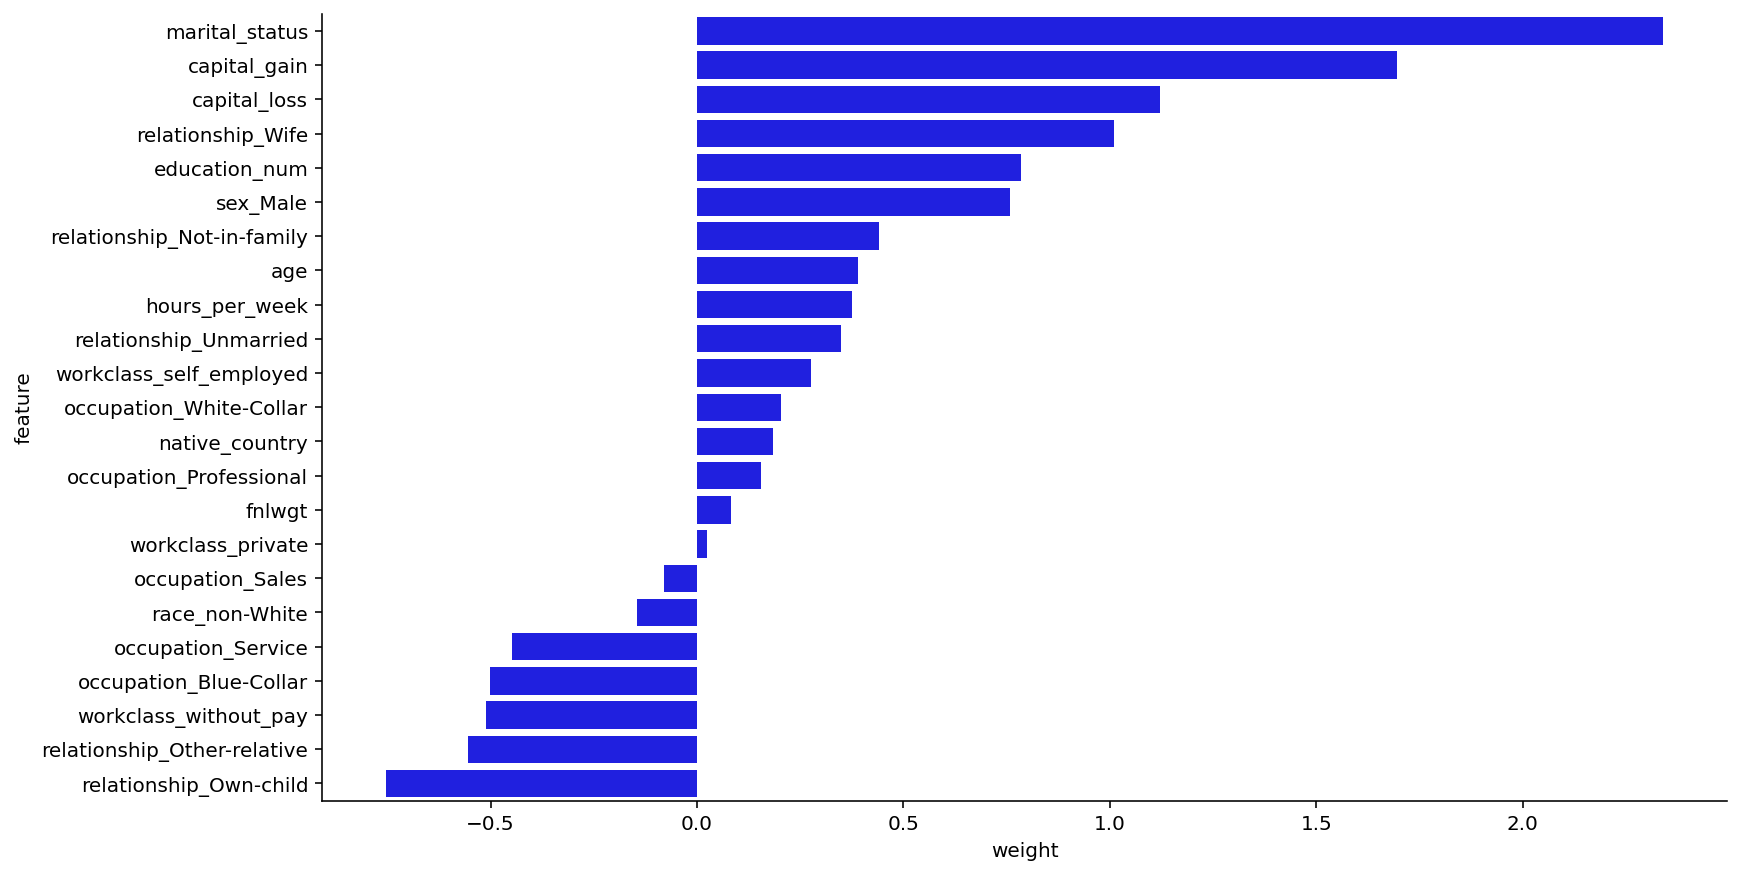

In [17]:
feat_imp = pd.DataFrame(clf.coef_[0], columns=['weight'])
feat_imp['feature'] = X_test_enc.columns
feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", color='b', aspect=2, height=6)

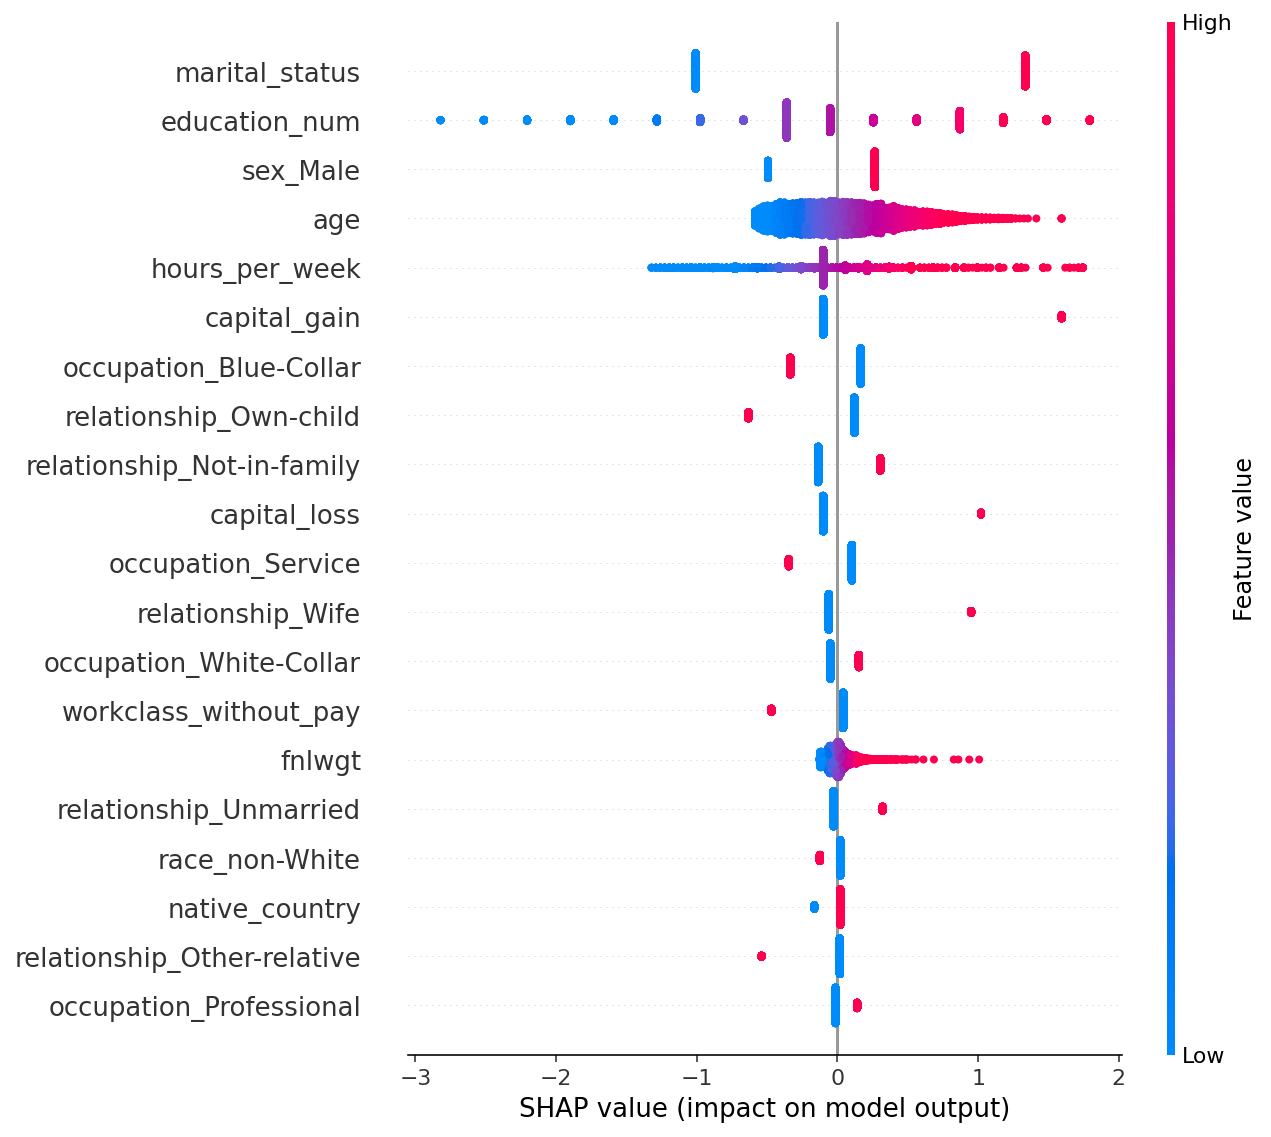

In [18]:
shap_summery(clf, X_test_enc, X_test_enc)

In [19]:
# rfc = RandomForestClassifier(max_depth=20, random_state=42)
# rfc.fit(X_train_enc, y_train)
# evaluate(rfc, X_test_enc, y_test)

# feat_imp = pd.DataFrame(rfc.feature_importances_, columns=['weight'])
# feat_imp['feature'] = X_train_enc.columns
# feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
# sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", 
# 			color="b", aspect=1.8, height=8)

Checking for bias in the conventional model

In [20]:
biased_pred = X_test.copy()
biased_pred['true'] = y_test
biased_pred['predicted'] = clf.predict(X_test_enc)

check_bias(biased_pred, "race", "White")
check_bias(biased_pred, "sex", "Male")
check_bias(biased_pred, "native_country", 1)

Checking for bias based on race
Privileged class White
-----------------------------------------------
                               value  biased
Statistical Parity Difference -0.099   False
Equal Opportunity Difference  -0.060   False
Average Odds Difference       -0.049   False
Disparate Impact               0.545    True 

Checking for bias based on sex
Privileged class Male
-----------------------------------------------
                               value  biased
Statistical Parity Difference -0.200    True
Equal Opportunity Difference  -0.170    True
Average Odds Difference       -0.127    True
Disparate Impact               0.255    True 

Checking for bias based on native_country
Privileged class 1
-----------------------------------------------
                               value  biased
Statistical Parity Difference -0.052   False
Equal Opportunity Difference  -0.007   False
Average Odds Difference       -0.013   False
Disparate Impact               0.752    True 



## 3.3.4 Unbiased split of the data into training and testing set

Uniform Sampling
- Deprived groups - Female and/or non-White
- Favored groups - Male and/or White
- Positive label - `salary == 1`
- Negative label - `salary == 0`

In [21]:
data['demo_groups'] = data['sex'] + data['race'].astype(str) + data['salary'].astype(str)
data.demo_groups.value_counts()

MaleWhite0          18214
FemaleWhite0        10404
MaleWhite1           8733
Malenon-White0       2712
Femalenon-White0     2596
FemaleWhite1         1452
Malenon-White1        786
Femalenon-White1      214
Name: demo_groups, dtype: int64

Here
- Deprived groups with positive labels - `'FemaleWhite1', 'Malenon-White1', 'Femalenon-White1'`
- Deprived groups with negative labels - `'FemaleWhite0', 'Malenon-White0', 'Femalenon-White0'`
- Favoured groups with positive labels - `'MaleWhite1'`
- Favoured groups with negative labels - `'MaleWhite0'`

In [22]:
# Split data while preserving the proportions of the 8 demographic groups stated above
uniform_sample = data.groupby('demo_groups').apply(lambda x: x.sample(data.shape[0], replace=True))
X = uniform_sample.drop(['salary'], axis=1)
y = uniform_sample['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                    stratify=uniform_sample.demo_groups)

# Drop the demo_group column from X_test and X_train as it's not required
X_train = X_train.drop(['demo_groups'], axis=1)
X_test = X_test.drop(['demo_groups'], axis=1)

# One hot encoding catgorical features
X_train_enc = pd.get_dummies(X_train, columns=enc_columns, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=enc_columns, drop_first=True)

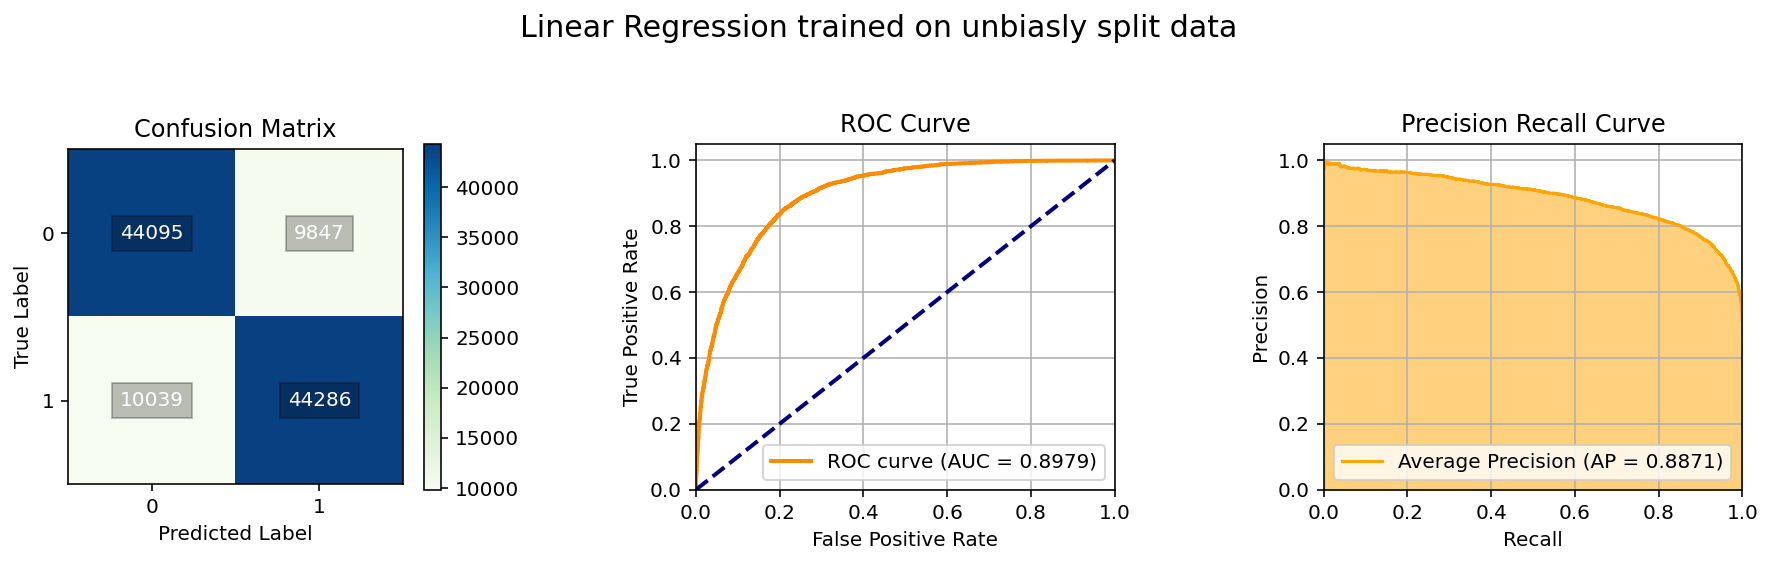

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     54134
           1       0.82      0.82      0.82     54133

    accuracy                           0.82    108267
   macro avg       0.82      0.82      0.82    108267
weighted avg       0.82      0.82      0.82    108267



In [23]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train_enc, y_train)
evaluate(clf, X_test_enc, y_test, 'Linear Regression trained on unbiasly split data')

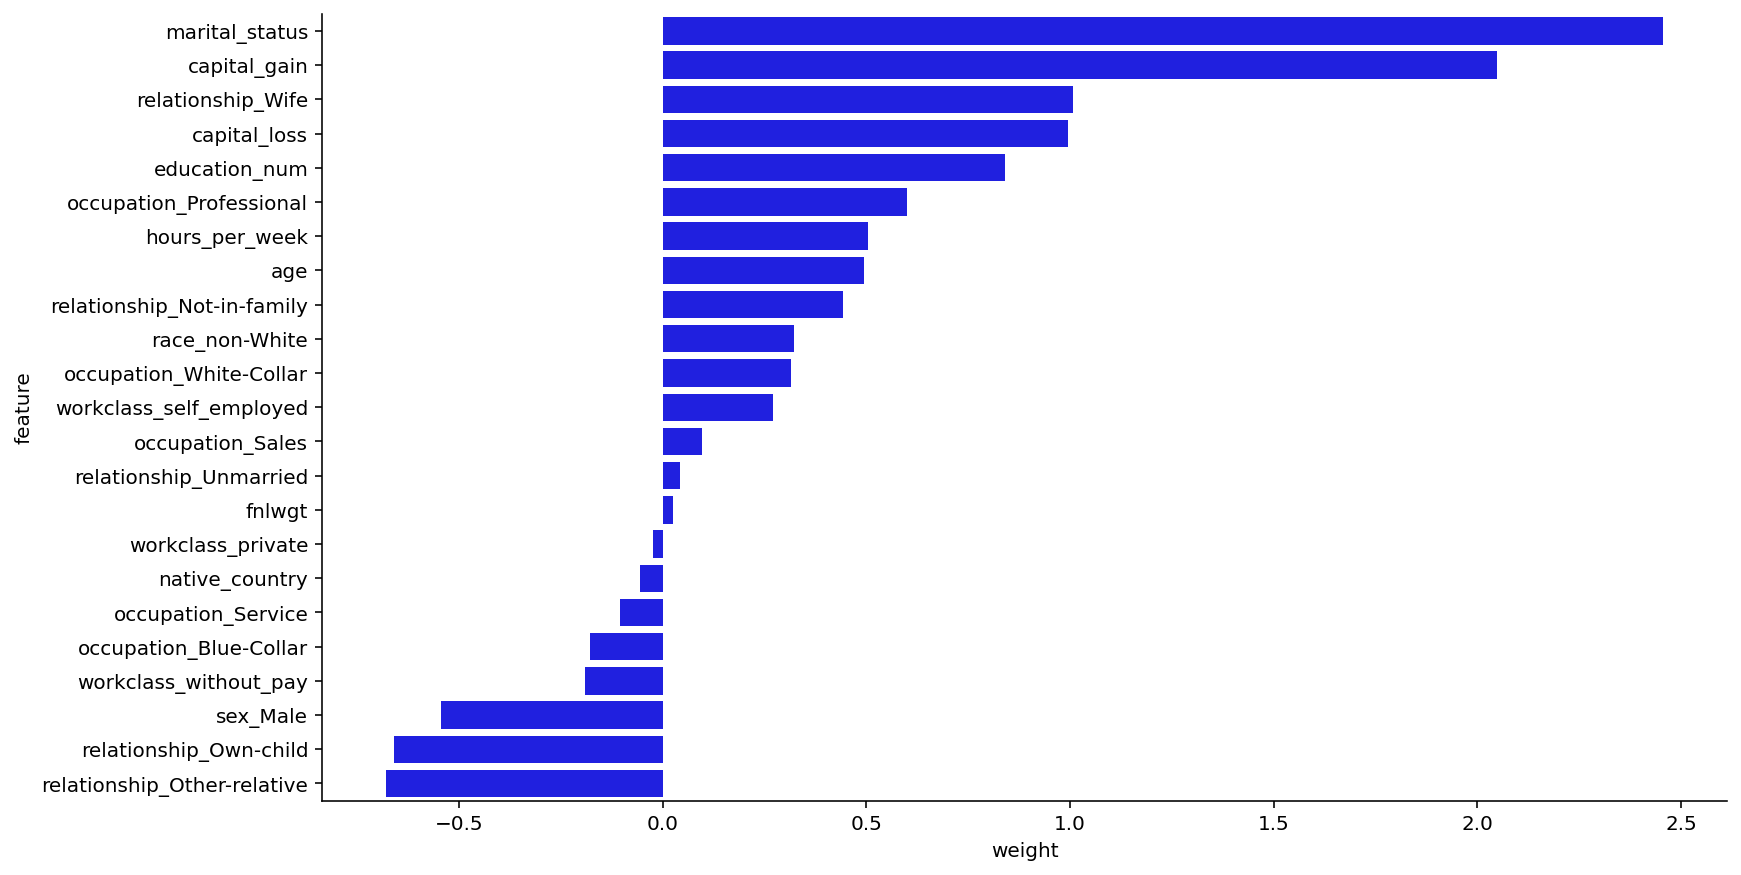

In [24]:
feat_imp = pd.DataFrame(clf.coef_[0], columns=['weight'])
feat_imp['feature'] = X_test_enc.columns
feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", color='b', aspect=2, height=6)

In [25]:
debiased_pred = X_test.copy()
debiased_pred['true'] = y_test
debiased_pred['predicted'] = clf.predict(X_test_enc)

check_bias(debiased_pred, "race", "White")
check_bias(debiased_pred, "sex", "Male")
check_bias(debiased_pred, "native_country", 1)

Checking for bias based on race
Privileged class White
-----------------------------------------------
                               value  biased
Statistical Parity Difference  0.000   False
Equal Opportunity Difference   0.024   False
Average Odds Difference        0.000   False
Disparate Impact               1.001   False 

Checking for bias based on sex
Privileged class Male
-----------------------------------------------
                               value  biased
Statistical Parity Difference -0.019   False
Equal Opportunity Difference   0.034   False
Average Odds Difference       -0.019   False
Disparate Impact               0.962   False 

Checking for bias based on native_country
Privileged class 1
-----------------------------------------------
                               value  biased
Statistical Parity Difference  0.069   False
Equal Opportunity Difference   0.007   False
Average Odds Difference        0.031   False
Disparate Impact               1.140   False 



# Task 3.4 Fair machine learning implementation

In [26]:
# to do